# Segmenting and Clustering Similar Towns in Massachusetts Based on Venues

Import the necessary libraries

In [1]:
import pandas as pd
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  

     |████████████████████████████████| 79 kB 6.9 MB/s eta 0:00:011
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=32e77acbf956f2ecf787dd352fcdf635a2759b68f7ffb7e7c43494577284b975
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium


In [2]:
url_towns='https://en.wikipedia.org/wiki/List_of_Massachusetts_locations_by_per_capita_income'
list_towns=pd.read_html(url_towns)[2]
list_towns

,Rank,Municipality,Type,County,Per capitaincome,Medianhouseholdincome,Medianfamilyincome,Population,Number ofhouseholds
0,1.0,Weston,Town,Middlesex,"$105,217","$192,563","$250,000+",11538,3769
1,2.0,Dover,Town,Norfolk,"$89,476","$187,829","$193,750",5677,1891
2,3.0,Carlisle,Town,Middlesex,"$77,585","$160,034","$175,833",4918,1745
3,4.0,Sherborn,Town,Middlesex,"$73,420","$223,444","$164,063",4169,1427
4,5.0,Sudbury,Town,Middlesex,"$72,744","$170,924","$186,507",17922,5783
...,...,...,...,...,...,...,...,...,...
348,347.0,Chelsea,City,Suffolk,"$20,617","$47,291","$48,849",36222,11550
349,348.0,Holyoke,City,Hampden,"$19,968","$31,628","$37,299",40029,15846
350,349.0,Amherst,Town,Hampshire,"$19,796","$53,191","$96,733",38651,8583
351,350.0,Springfield,City,Hampden,"$18,133","$34,311","$39,535",153428,55894


In [3]:
df = list_towns.dropna() #note two rows are removed
df

,Rank,Municipality,Type,County,Per capitaincome,Medianhouseholdincome,Medianfamilyincome,Population,Number ofhouseholds
0,1.0,Weston,Town,Middlesex,"$105,217","$192,563","$250,000+",11538,3769
1,2.0,Dover,Town,Norfolk,"$89,476","$187,829","$193,750",5677,1891
2,3.0,Carlisle,Town,Middlesex,"$77,585","$160,034","$175,833",4918,1745
3,4.0,Sherborn,Town,Middlesex,"$73,420","$223,444","$164,063",4169,1427
4,5.0,Sudbury,Town,Middlesex,"$72,744","$170,924","$186,507",17922,5783
...,...,...,...,...,...,...,...,...,...
348,347.0,Chelsea,City,Suffolk,"$20,617","$47,291","$48,849",36222,11550
349,348.0,Holyoke,City,Hampden,"$19,968","$31,628","$37,299",40029,15846
350,349.0,Amherst,Town,Hampshire,"$19,796","$53,191","$96,733",38651,8583
351,350.0,Springfield,City,Hampden,"$18,133","$34,311","$39,535",153428,55894


Create a dataframe with only the needed column of Municipality.

In [4]:
df = df.drop(['Rank','Type','County','Per capitaincome','Medianhouseholdincome','Medianfamilyincome','Population','Number ofhouseholds'],axis=1)
df.columns = ["Neighborhood"]
df

,Neighborhood
0,Weston
1,Dover
2,Carlisle
3,Sherborn
4,Sudbury
...,...
348,Chelsea
349,Holyoke
350,Amherst
351,Springfield


Create a new dataframe consisting of Towns.

In [5]:
df.shape

(351, 1)

Find the latitude and longitude coordinates for each town.

In [6]:
geolocator = Nominatim(user_agent="my_user_agent")

list_latitude = []
list_longitude = []

for town in df["Neighborhood"]:
    town = town
    state = "Massachusetts"
    loc = geolocator.geocode(town+','+ state)
    list_latitude.append(loc.latitude)
    list_longitude.append(loc.longitude)

Add the latitude and longitude to the dataframe.

In [7]:
df['Latitude']=list_latitude
df['Longitude']=list_longitude
df

,Neighborhood,Latitude,Longitude
0,Weston,42.366763,-71.303113
1,Dover,42.245931,-71.282834
2,Carlisle,42.529260,-71.349505
3,Sherborn,42.238986,-71.369781
4,Sudbury,42.383428,-71.416173
...,...,...,...
348,Chelsea,42.391764,-71.032828
349,Holyoke,42.207143,-72.607650
350,Amherst,42.368566,-72.505714
351,Springfield,42.101876,-72.588673


## Clustering
Import libraries to be used in this section.

Add credentials to access Foursquare API.

In [1]:
CLIENT_ID = '' #Foursquare ID
CLIENT_SECRET = '' #Foursquare Secret
ACCESS_TOKEN = '' #FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


Get the latitude and longitude of Massachusetts.

In [9]:
address = "Massachusetts"

geolocator = Nominatim(user_agent="massachusetts_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Massachusetts are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Massachusetts are 42.3788774, -72.032366.


In [10]:
df['State'] = 'Massachusetts'

Use the coordinates to create a map of Massachusetts with markers for each county.

In [11]:
map_MA = folium.Map(location=[latitude, longitude], zoom_start=8)
map_MA

for lat, lng, town, state in zip(
        df['Latitude'], 
        df['Longitude'],
        df['Neighborhood'],
        df['State']):
    label = '{}, {}'.format(town, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_MA)  

map_MA

Create the URL to access the venues within a 500 meter radius from the Parkwoods.

Create a function to explore venues in all the neighborhoods in Toronto.

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get the neighborhoods from the function created above and create a dataframe with it.

In [13]:
town_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])

Weston
Dover
Carlisle
Sherborn
Sudbury
Wellesley
Winchester
Manchester-by-the-Sea
Lexington
Boxford
Wayland
Concord
Brookline
Norwell
Newton
Needham
Westwood
Southborough
Medfield
Lincoln
Boxborough
Cohasset
Hingham
Marblehead
Hopkinton
Belmont
Topsfield
Bolton
Alford
Duxbury
Longmeadow
Acton
Boylston
Sharon
Richmond
West Newbury
Stow
Andover
Harvard
Pelham
Tyringham
Holliston
Arlington
Westford
Mount Washington
Scituate
Chelmsford
Swampscott
Groton
Dunstable
Littleton
Cambridge
Nantucket
Reading
North Andover
Lynnfield
Wenham
Natick
Milton
Newburyport
Canton
Westborough
Ashland
Nahant
Marion
Provincetown
Chatham
North Reading
Wrentham
Watertown
Hamilton
Berlin
Chilmark
Northborough
Medway
Georgetown
Marshfield
Norfolk
Dedham
Ipswich
Princeton
Walpole
Foxborough
Upton
Bedford
Melrose
Sutton
Essex
Mansfield
Franklin
Newbury
Rockport
Mendon
Orleans
Hanover
Burlington
Hull
Tyngsborough
Holden
Sterling
Leverett
Egremont
Groveland
Wakefield
Shrewsbury
Grafton
Tolland
Tewksbury
Millis
Falmou

In [14]:
town_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Weston,42.366763,-71.303113,Dumpling Daughter,42.366820,-71.300544,Peking Duck Restaurant
1,Weston,42.366763,-71.303113,Theo's Pizzeria & Grille,42.367089,-71.301650,Pizza Place
2,Weston,42.366763,-71.303113,Brothers Marketplace,42.366831,-71.300548,Market
3,Weston,42.366763,-71.303113,bruegger's Weston,42.366701,-71.300848,Bagel Shop
4,Weston,42.366763,-71.303113,Ye Olde Cottage Restaurant,42.367537,-71.300832,Diner


Find the number of venues returned by each neighborhood.

In [15]:
town_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abington,9,9,9,9,9,9
Acton,4,4,4,4,4,4
Acushnet,10,10,10,10,10,10
Adams,13,13,13,13,13,13
Alford,1,1,1,1,1,1
...,...,...,...,...,...,...
Winthrop,16,16,16,16,16,16
Woburn,28,28,28,28,28,28
Worcester,10,10,10,10,10,10


In [16]:
print('There are {} uniques categories.'.format(len(town_venues['Venue Category'].unique())))

There are 307 uniques categories.


Create a dataframe with dummy variables denoting types of venues in each county.

In [17]:
# one hot encoding
town_onehot = pd.get_dummies(town_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
town_onehot['Neighborhood'] = town_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [town_onehot.columns[-1]] + list(town_onehot.columns[:-1])
town_onehot = town_onehot[fixed_columns]

town_onehot.head()

,Yoga Studio,ATM,Acupuncturist,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
town_onehot.shape

(3164, 307)

Find the average of the frequency of occurrence in each category by grouping by the town.

In [19]:
town_grouped = town_onehot.groupby('Neighborhood').mean().reset_index()
town_grouped.head()

,Neighborhood,Yoga Studio,ATM,Acupuncturist,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Abington,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
1,Acton,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Acushnet,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Adams,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Alford,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
town_grouped.shape

(259, 307)

Find the top 5 most common venues.

In [21]:
num_top_venues = 5

for hood in town_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = town_grouped[town_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abington----
          venue  freq
0   Pizza Place  0.11
1   Video Store  0.11
2       Brewery  0.11
3  Liquor Store  0.11
4   Coffee Shop  0.11


----Acton----
           venue  freq
0  Historic Site  0.25
1     Playground  0.25
2    Pizza Place  0.25
3          Trail  0.25
4    Yoga Studio  0.00


----Acushnet----
                 venue  freq
0  American Restaurant   0.2
1          Post Office   0.1
2           Steakhouse   0.1
3   Chinese Restaurant   0.1
4       Breakfast Spot   0.1


----Adams----
                 venue  freq
0                  Bar  0.15
1          Pizza Place  0.15
2    Electronics Store  0.08
3  Martial Arts School  0.08
4   Chinese Restaurant  0.08


----Alford----
                     venue  freq
0              IT Services   1.0
1              Yoga Studio   0.0
2  New American Restaurant   0.0
3        Outdoor Sculpture   0.0
4        Other Repair Shop   0.0


----Amesbury----
                 venue  freq
0  American Restaurant  0.17
1          Pizza Place

Sort the venues in descending occurence order.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Find the 10 most common venues for each town.

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = town_grouped['Neighborhood']

for ind in np.arange(town_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(town_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abington,Sandwich Place,Video Store,Chinese Restaurant,Coffee Shop,Convenience Store,Liquor Store,American Restaurant,Brewery,Pizza Place,Fast Food Restaurant
1,Acton,Trail,Playground,Pizza Place,Historic Site,Women's Store,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market
2,Acushnet,American Restaurant,Post Office,Breakfast Spot,Convenience Store,Pizza Place,Diner,Steakhouse,Chinese Restaurant,Donut Shop,Financial or Legal Service
3,Adams,Bar,Pizza Place,Ice Cream Shop,Martial Arts School,Liquor Store,Sandwich Place,Electronics Store,Chinese Restaurant,Tourist Information Center,Park
4,Alford,IT Services,Women's Store,Fish & Chips Shop,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service


Find the optimal number of clusters using the elbow method.

In [24]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

town_grouped_clustering = town_grouped.drop('Neighborhood', 1)
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(town_grouped_clustering) 
    kmeanModel.fit(town_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(town_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / town_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(town_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / town_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

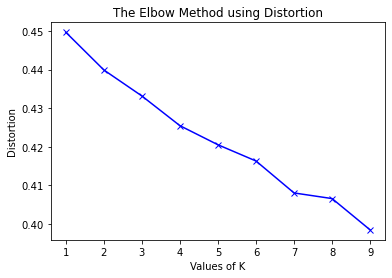

In [25]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

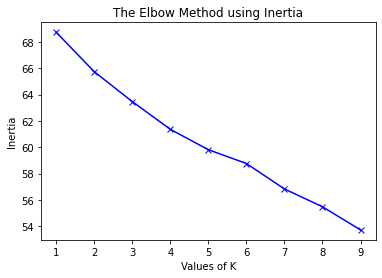

In [26]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Run k-means to cluster the neighborhood into 6 clusters.

In [27]:
# set number of clusters
kclusters = 6

town_grouped_clustering = town_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(town_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 2], dtype=int32)

Create a dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [28]:
df_town = df[['Neighborhood','Latitude','Longitude']]
df_town

,Neighborhood,Latitude,Longitude
0,Weston,42.366763,-71.303113
1,Dover,42.245931,-71.282834
2,Carlisle,42.529260,-71.349505
3,Sherborn,42.238986,-71.369781
4,Sudbury,42.383428,-71.416173
...,...,...,...
348,Chelsea,42.391764,-71.032828
349,Holyoke,42.207143,-72.607650
350,Amherst,42.368566,-72.505714
351,Springfield,42.101876,-72.588673


In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
df_MA = df_town
df_MA.columns = ['Neighborhood','Latitude','Longitude']

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_MA = df_MA.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_MA.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Weston,42.366763,-71.303113,0.0,Coffee Shop,Diner,Bagel Shop,Market,Peking Duck Restaurant,Pharmacy,Grocery Store,Pizza Place,Fishing Spot,Fish Market
1,Dover,42.245931,-71.282834,1.0,Post Office,Deli / Bodega,Donut Shop,Grocery Store,Flower Shop,Food,Flea Market,Fishing Store,Fishing Spot,Fish Market
2,Carlisle,42.529260,-71.349505,1.0,Sandwich Place,Women's Store,Film Studio,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service
3,Sherborn,42.238986,-71.369781,0.0,Convenience Store,Pizza Place,Sandwich Place,Donut Shop,Pet Store,Women's Store,Fast Food Restaurant,Event Space,Exhibit,Fabric Shop
4,Sudbury,42.383428,-71.416173,0.0,Italian Restaurant,Pizza Place,Donut Shop,Women's Store,Financial or Legal Service,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant


Convert column 'Cluster Lables' to an integer type to be used to make a map.

In [30]:
df_map_MA = df_MA
df_map_MA['Cluster Labels'] = df_map_MA['Cluster Labels'].fillna(0.0).astype(int)
df_map_MA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 352
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            351 non-null    object 
 1   Latitude                351 non-null    float64
 2   Longitude               351 non-null    float64
 3   Cluster Labels          351 non-null    int64  
 4   1st Most Common Venue   259 non-null    object 
 5   2nd Most Common Venue   259 non-null    object 
 6   3rd Most Common Venue   259 non-null    object 
 7   4th Most Common Venue   259 non-null    object 
 8   5th Most Common Venue   259 non-null    object 
 9   6th Most Common Venue   259 non-null    object 
 10  7th Most Common Venue   259 non-null    object 
 11  8th Most Common Venue   259 non-null    object 
 12  9th Most Common Venue   259 non-null    object 
 13  10th Most Common Venue  259 non-null    object 
dtypes: float64(2), int64(1), object(11)
memory

Create a map of the clusters. 

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_MA['Latitude'], df_MA['Longitude'], df_MA['Neighborhood'], df_MA['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1
Examine cluster 1.

In [32]:
df_MA.loc[df_MA['Cluster Labels'] == 0, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Weston,Coffee Shop,Diner,Bagel Shop,Market,Peking Duck Restaurant,Pharmacy,Grocery Store,Pizza Place,Fishing Spot,Fish Market
3,Sherborn,Convenience Store,Pizza Place,Sandwich Place,Donut Shop,Pet Store,Women's Store,Fast Food Restaurant,Event Space,Exhibit,Fabric Shop
4,Sudbury,Italian Restaurant,Pizza Place,Donut Shop,Women's Store,Financial or Legal Service,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant
10,Wayland,Home Service,Thai Restaurant,Athletics & Sports,Chinese Restaurant,Pizza Place,Pharmacy,Event Space,Exhibit,Fabric Shop,Farm
16,Westwood,Cosmetics Shop,Café,Chinese Restaurant,Pizza Place,Home Service,Donut Shop,Women's Store,Fast Food Restaurant,Exhibit,Fabric Shop
...,...,...,...,...,...,...,...,...,...,...,...
342,Brockton,Chinese Restaurant,Lounge,Pub,Pizza Place,Automotive Shop,Bus Station,Asian Restaurant,Financial or Legal Service,Fabric Shop,Farm
346,Orange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348,Chelsea,Pizza Place,Spanish Restaurant,Mexican Restaurant,Donut Shop,Fast Food Restaurant,Bagel Shop,Thai Restaurant,Discount Store,Bank,Pharmacy
349,Holyoke,Pizza Place,Spanish Restaurant,Art Gallery,Bar,Bakery,Fast Food Restaurant,Storage Facility,Park,Trail,American Restaurant


### Cluster 2
Examine cluster 2.

In [33]:
x = df_MA.loc[df_MA['Cluster Labels'] == 1, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]
x

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Dover,Post Office,Deli / Bodega,Donut Shop,Grocery Store,Flower Shop,Food,Flea Market,Fishing Store,Fishing Spot,Fish Market
2,Carlisle,Sandwich Place,Women's Store,Film Studio,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service
5,Wellesley,Coffee Shop,Pizza Place,Arts & Crafts Store,Mediterranean Restaurant,Italian Restaurant,Thai Restaurant,Yoga Studio,Men's Store,Mattress Store,Tapas Restaurant
6,Winchester,New American Restaurant,Italian Restaurant,Coffee Shop,Cupcake Shop,Donut Shop,Pharmacy,Café,Gastropub,Supermarket,Chinese Restaurant
7,Manchester-by-the-Sea,Café,Grocery Store,Diner,Bank,New American Restaurant,Other Great Outdoors,Train Station,Seafood Restaurant,Bookstore,Pharmacy
...,...,...,...,...,...,...,...,...,...,...,...
344,North Adams,Pharmacy,American Restaurant,Pizza Place,Mexican Restaurant,Art Museum,Discount Store,Hot Dog Joint,Multiplex,Bistro,Liquor Store
345,Fall River,Donut Shop,Café,Bus Station,Bar,Portuguese Restaurant,Gym,Pharmacy,Pub,Doctor's Office,Restaurant
347,New Bedford,Breakfast Spot,Fried Chicken Joint,American Restaurant,Laundromat,Fast Food Restaurant,Women's Store,Fish & Chips Shop,Fabric Shop,Farm,Farmers Market
351,Springfield,Hotel,Hockey Arena,Shipping Store,American Restaurant,Café,Donut Shop,Coffee Shop,Sports Bar,Sculpture Garden,Science Museum


### Cluster 3
Examine cluster 3.

In [34]:
df_MA.loc[df_MA['Cluster Labels'] == 2, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Bolton,Park,Business Service,Women's Store,Film Studio,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service
34,Richmond,Business Service,Women's Store,Financial or Legal Service,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop
201,Ashburnham,Business Service,Bed & Breakfast,Women's Store,Fish & Chips Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish Market
238,Blackstone,Vineyard,Business Service,Women's Store,Financial or Legal Service,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio
270,South Hadley,Furniture / Home Store,Business Service,Bed & Breakfast,Women's Store,Fish & Chips Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service
297,Buckland,Business Service,Women's Store,Financial or Legal Service,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop


### Cluster 4
Examine cluster 4.

In [35]:
df_MA.loc[df_MA['Cluster Labels'] == 3, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Reading,Park,Playground,Women's Store,Film Studio,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant
90,Newbury,Park,Butcher,Women's Store,Film Studio,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service
95,Burlington,Park,Baseball Field,Pizza Place,Gas Station,Women's Store,Financial or Legal Service,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant
135,Kingston,Baseball Field,River,Park,Museum,Home Service,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market
153,Deerfield,River,Women's Store,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service
159,Hampden,Post Office,Park,Italian Restaurant,Film Studio,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant
165,Charlton,Park,Women's Store,Financial or Legal Service,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop
209,Bourne,Post Office,Pharmacy,Park,Bar,Flea Market,Fishing Store,Fishing Spot,Fish Market,Flower Shop,Fish & Chips Shop
225,Swansea,Park,Dessert Shop,Business Service,Women's Store,Film Studio,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant
242,Freetown,Convenience Store,Park,Women's Store,Film Studio,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant


### Cluster 5
Examine cluster 5.

In [36]:
df_MA.loc[df_MA['Cluster Labels'] == 4, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
96,Hull,Scenic Lookout,American Restaurant,Women's Store,Financial or Legal Service,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio
110,New Ashford,American Restaurant,Women's Store,Fish & Chips Shop,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service
286,Oxford,American Restaurant,Women's Store,Fish & Chips Shop,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service


### Cluster 6
Examine cluster 6.

In [37]:
df_MA.loc[df_MA['Cluster Labels'] == 5, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,Wenham,Breakfast Spot,History Museum,Women's Store,Financial or Legal Service,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio
220,Berkley,Breakfast Spot,Grocery Store,Women's Store,Fish & Chips Shop,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service
289,Russell,Breakfast Spot,Women's Store,Fish & Chips Shop,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service
